<hr>

https://www.tensorflow.org/datasets/catalog/fashion_mnist

https://github.com/zalandoresearch/fashion-mnist

Fashion-MNIST is a dataset of clothing images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

In [3]:
import numpy as np
import numpy.random as R
import matplotlib.pyplot as plt

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    from tensorflow.keras.datasets import fashion_mnist
    from tensorflow.keras import models
    from tensorflow.keras import layers
    from tensorflow.keras import optimizers

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

flabels = {0 : 't-shirt',
           1 : 'trousers',
           2 : 'pullover',
           3 : 'dress',
           4 : 'coat',
           5 : 'sandal',
           6 : 'shirt',
           7 : 'sneaker',
           8 : 'bag',
           9 : 'boot'}

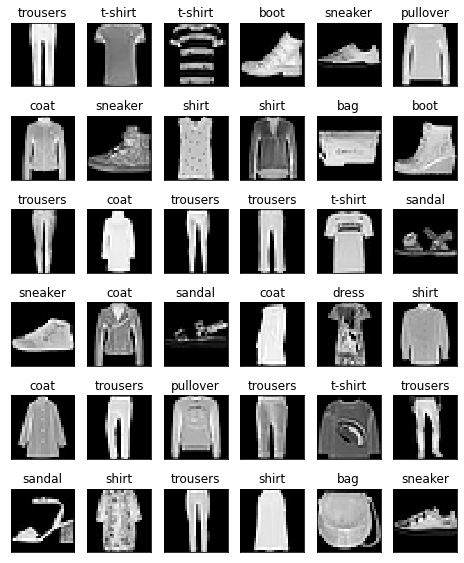

In [2]:
# display some images with their labels
fig = plt.figure(figsize=(8, 10))
N = 6
st_idx = R.randint(0, train_images.shape[0]-N*N-1)
for i in range(N*N):
    plt.subplot(N,N,i+1)
    plt.imshow(train_images[st_idx+i], cmap='gray', interpolation='none')
    plt.title(flabels[train_labels[st_idx+i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Q1: Autoassociator

Note on Homework 7 that for the autoencoder (Q1a), you should use linear activation functions on the outputs (as a regression-type problem). For this, I've asked you to have it develop PCA-like representations, which means also using linear activation functions on the hidden layer. With a regression-type problem, mean_squared_error is an appropriate loss function

(I just realized that the autoencoder code I shared in Homework 1 used a nonlinear hidden layer, which is fine but not PCA-like, had sigmoidal output activations, which is ok since the pixel values are normalized to fall between 0 and 1, but had an inappropriate objective function - I think I copied that code from someplace at one time and hadn't bothered to check it closely since it was just a quick demo to make sure Keras/Tensorflow was working.)

In [7]:
def plot_model_loss(history):
    """Loss Plotting Function"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss As a Function of Number of Epochs Trained')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

In [8]:
print(train_images.shape)
new_dim = train_images.shape[1] * train_images.shape[2]
train_2D = np.reshape(train_images, (train_images.shape[0], new_dim))
print(train_2D.shape)

(60000, 28, 28)
(60000, 784)


In [14]:
print(train_labels.shape)
print(train_labels.shape[0])

(60000,)
60000


In [15]:
train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))

shuffled_idx = R.permutation(train_2D.shape[0])
train_shuffled = train_2D[shuffled_idx,:]
train_labels_shuffled = train_labels[shuffled_idx,:]

train_half = train_shuffled[0:train_shuffled.shape[0]//2]
train_labels_half = train_labels_shuffled[0:train_shuffled.shape[0]//2]

In [16]:
print(train_half.shape)
print(train_labels_half.shape)

(30000, 784)
(30000, 1)


In [17]:
def create_autonetwork(test_dim, input_dim):
    network = models.Sequential()

    network.add(layers.Dense(test_dim, 
                     activation='linear', 
                     input_shape=(input_dim,)))
    network.add(layers.Dense(input_dim, 
                     activation='linear', 
                     input_shape=(test_dim,)))

    # configure optimizer
    # sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9)
    network.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy', 'mse'])
    
    return network

In [31]:
input_dim = train_half.shape[1]
print(input_dim)

test_dim = 100

network = models.Sequential()

network.add(layers.Dense(test_dim, 
                 activation='relu', 
                 input_shape=(input_dim,)))
network.add(layers.Dense(input_dim, 
                 activation='linear', 
                 input_shape=(test_dim,)))

# configure optimizer
# sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9)
network.compile(optimizer='adam', 
                loss='mean_squared_error', 
                metrics=['accuracy', 'mse'])

784


In [32]:
print(train_half.shape)
print(train_labels_half.shape)

(30000, 784)
(30000, 1)


In [33]:
 history = network.fit(train_half, 
                              train_labels_half, 
                              verbose=False, 
                              validation_split=.2, 
                              epochs=30, 
                              batch_size=1)

ValueError: A target array with shape (30000, 1) was passed for an output of shape (None, 784) while using as loss `mean_squared_error`. This loss expects targets to have the same shape as the output.

In [22]:
def run_pipeline(train_array, train_labels, test_dim, test_pats=None, test_labels=None, num_epochs=30, my_batch=1):
    best_acc = -1
    best_val_acc = -1
    
    input_dim = train_array.shape[1]
    
    for _ in range(5):
        network = create_autonetwork(test_dim, input_dim)
        
        history = network.fit(train_array, 
                              train_labels, 
                              verbose=False, 
                              validation_split=.2, 
                              epochs=num_epochs, 
                              batch_size=my_batch)
        print('Done training!')
        
        # Determine if this model was better than the previous ones
        new_acc = history.history['acc'][-1]
        new_val_acc = history.history['val_acc'][-1]
        if new_acc > best_acc and new_val_acc > best_val_acc:
            best_acc = new_acc
            best_val_acc = new_val_acc
            best_history = history
            best_network = network
        # Show the accuracy plot each time
        # plot_model_acc(history)

    # Show the accuracy of the best plot
    plot_model_acc(best_history)
    
    '''
    out = best_network.predict(
       test_pats, 
       batch_size = my_batch, 
       verbose = 0,  
       workers = 1, 
       use_multiprocessing = False)
    
    results = best_network.evaluate(test_pats, 
                           test_labels_onehot_2D, 
                           verbose=False)

    test_loss = results[0]
    test_acc = results[1]

    print('test_loss (MSE)     : {}'.format(test_loss))
    print('test_acc (%Correct) : {}'.format(test_acc))
    '''
    
    return best_network, best_history #, out, results

In [23]:
run_pipeline(train_half, train_labels_half, 100)

ValueError: A target array with shape (30000, 1) was passed for an output of shape (None, 784) while using as loss `mean_squared_error`. This loss expects targets to have the same shape as the output.